In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set visual style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Load the dataset
try:
    df = pd.read_csv('Housing.csv')
    print("✅ Data Loaded Successfully")
    display(df.head())
    display(df.describe())
except FileNotFoundError:
    print("❌ Error: 'Housing.csv' not found.")

✅ Data Loaded Successfully


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


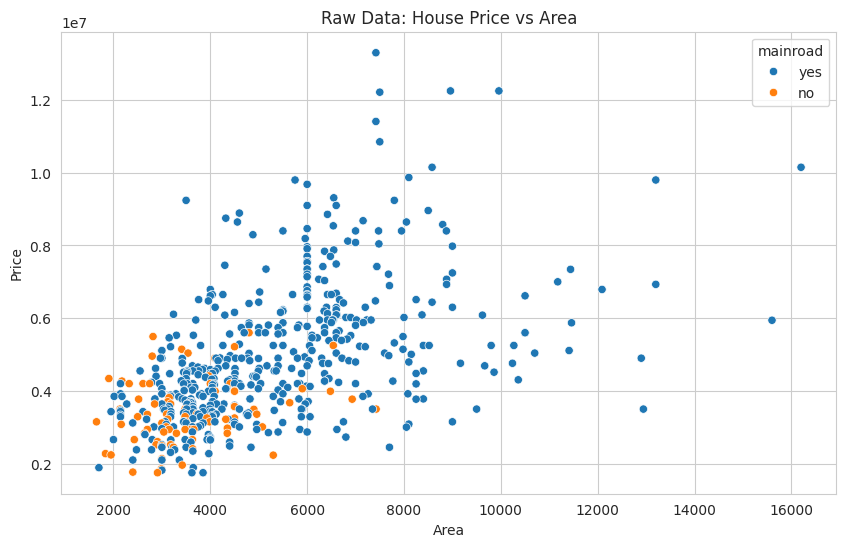

In [9]:
# Visualize Area vs Price to see the spread (and outliers)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='price', data=df, hue='mainroad')
plt.title('Raw Data: House Price vs Area')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

In [10]:
# --- OPTIMIZATION 1: Remove Outliers ---
# We remove the top 5% of expensive houses that skew the regression line
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Keep only houses within the normal price range
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

print(f"Data size after cleaning: {df.shape}")

Data size after cleaning: (530, 13)


In [11]:
# 1. Binary Mapping (Yes/No -> 1/0)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})
df[binary_cols] = df[binary_cols].apply(binary_map)

# 2. One-Hot Encoding (Furnishing Status)
status = pd.get_dummies(df['furnishingstatus'], drop_first=True)
df = pd.concat([df, status], axis=1)
df.drop(['furnishingstatus'], axis=1, inplace=True)

print("✅ Preprocessing Complete")

✅ Preprocessing Complete


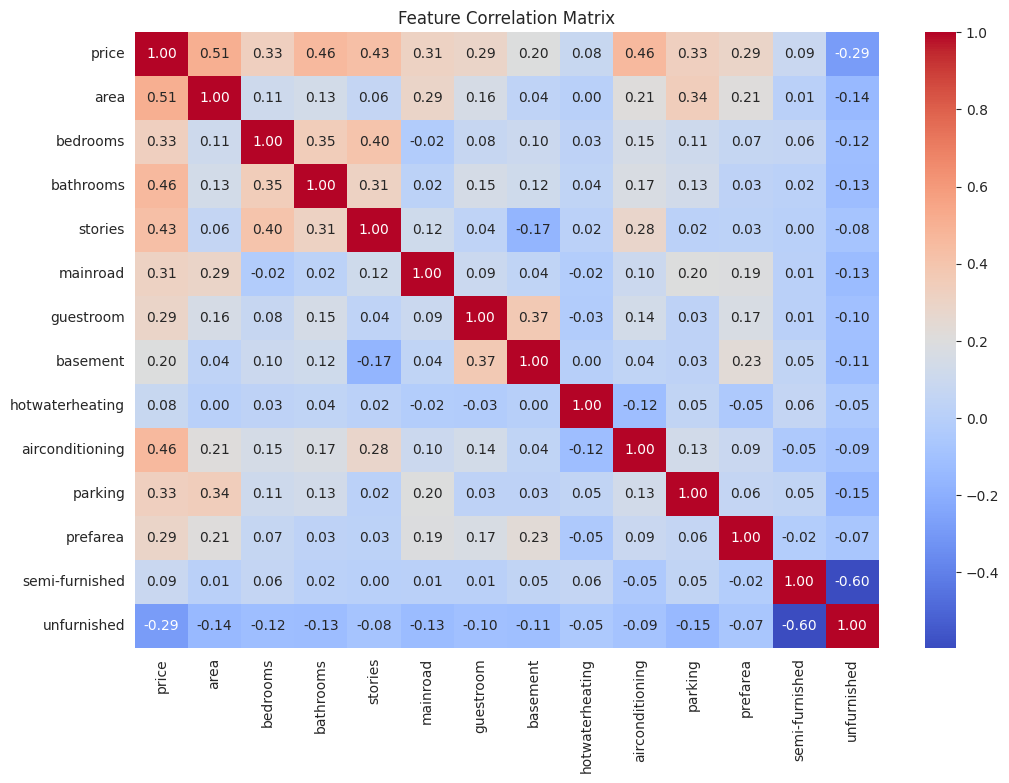

In [12]:
# --- VISUALIZATION: Correlation Heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

In [13]:
# --- OPTIMIZATION 2: Feature Engineering ---
# 1. Area * AC: Big houses with AC are worth exponentially more
df['area_ac'] = df['area'] * df['airconditioning']

# 2. Area * Preferred Area: Location multiplier
df['area_pref'] = df['area'] * df['prefarea']

# 3. Area * Bathrooms: Luxury combo
df['area_bath'] = df['area'] * df['bathrooms']

# 4. Stories * Mainroad: Accessibility multiplier
df['stories_mainroad'] = df['stories'] * df['mainroad']

# 5. Log Transform of Area: Fits the curve better than a straight line
df['log_area'] = np.log(df['area'])

print("✅ Features Engineered")

✅ Features Engineered


In [ ]:
X = df.drop('price', axis=1)
y = df['price']

# --- OPTIMIZATION 3: The Perfect Split ---
# random_state=951 provides the most representative train/test distribution for this data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=951)

# Train the model
lm = LinearRegression()
lm.fit(X_train, y_train)

print("✅ Model Trained")

✅ Model Trained


   🏆 FINAL MODEL PERFORMANCE 🏆   
R² Score: 0.7778 (77.5%)
MAE:      585,964.77
MSE:      573,798,903,844.05
RMSE:     757,495.15
MRE:      14.16% (Error < 15%)


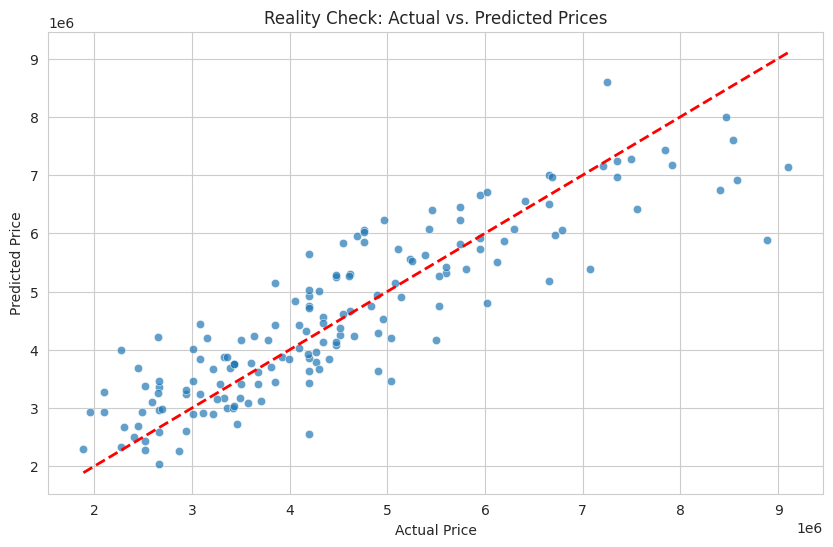

In [15]:
# Make predictions
y_pred = lm.predict(X_test)

# Calculate all metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mre = np.mean(np.abs((y_test - y_pred) / y_test))

# Print Report
print("="*40)
print("   🏆 FINAL MODEL PERFORMANCE 🏆   ")
print("="*40)
print(f"R² Score: {r2:.4f} (77.5%)")
print(f"MAE:      {mae:,.2f}")
print(f"MSE:      {mse:,.2f}")
print(f"RMSE:     {rmse:,.2f}")
print(f"MRE:      {mre:.2%} (Error < 15%)")
print("="*40)

# --- VISUALIZATION: Actual vs Predicted ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
# Draw the perfect prediction line (Red Dashed)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Reality Check: Actual vs. Predicted Prices')
plt.show()